In [287]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [288]:
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

# Scratch notebook for handling long stop to stop segments

* goal is to provide additional map detail for rural/express routes

In [289]:
## KART speedmap as displayed on site
itp_id = 148
analysis_date = dt.date(2022, 6, 1)

In [290]:
pbar = tqdm()

0it [00:00, ?it/s]

In [291]:
kart_analysis = rt.OperatorDayAnalysis(itp_id, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet
found parquet
could not interpolate segments for shape 73
could not interpolate segments for shape 1
could not interpolate segments for shape 21
could not interpolate segments for shape 23
could not interpolate segments for shape 36


In [323]:
kart_analysis.position_interpolators['555']['rt'].cleaned_positions.size

192

In [310]:
kart_analysis.rt_trips >> filter(_.route_id == '4')

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_short_name,route_long_name,route_desc,route_type,median_time,direction,mean_speed_mph,calitp_agency_name
238,148,0,2022-06-01,3683384997798773001,159,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,08:11:07,Southbound,13.475740,Kings Area Rural Transit
242,148,0,2022-06-01,5152118522550453779,557,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,18:09:02.500000,Eastbound,16.285926,Kings Area Rural Transit
243,148,0,2022-06-01,6180399639242712105,555,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,17:11:02,Westbound,11.793570,Kings Area Rural Transit
249,148,0,2022-06-01,9112420294498842451,160,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,08:42:08,Southbound,14.570360,Kings Area Rural Transit
250,148,0,2022-06-01,-7501798025289336090,554,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,16:40:18,Southbound,16.522262,Kings Area Rural Transit
251,148,0,2022-06-01,5090114771702269837,181,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,12:10:07,Westbound,16.319903,Kings Area Rural Transit
253,148,0,2022-06-01,-8953108643007388586,560,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,19:37:47,Southbound,17.289663,Kings Area Rural Transit
257,148,0,2022-06-01,6534366263451751462,180,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,11:42:08,Southbound,14.141055,Kings Area Rural Transit
260,148,0,2022-06-01,2606519258021614617,182,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,12:40:07,Westbound,16.260178,Kings Area Rural Transit
261,148,0,2022-06-01,1098851264720753664,185,4,1,20,2021-07-02,2099-01-01,4,Brown Line,None,3,14:10:33,Westbound,16.232715,Kings Area Rural Transit


In [292]:
positions = kart_analysis.position_interpolators['947']['rt'].position_gdf

In [293]:
positions = (positions >> mutate(veh_time = _.vehicle_timestamp.apply(lambda x: x.strftime('%H:%M:%S')))
             >> select(_.shape_meters, _.veh_time, _.geometry)
            )

In [294]:
cleaned_positions = (kart_analysis.position_interpolators['947']['rt'].cleaned_positions >> mutate(veh_time = _.vehicle_timestamp.apply(lambda x: x.strftime('%H:%M:%S')))
                    >> select(_.shape_meters, _.veh_time, _.geometry)
                    )

In [295]:
((cleaned_positions >> filter(_.shape_meters > 133546) >> filter(_.shape_meters == _.shape_meters.min())).geometry.iloc[0]).wkt

'POINT (16924.60674809301 -191169.82134810043)'

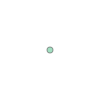

In [296]:
Point(16924.60674809301, -191169.82134810043)

In [297]:
# pd.concat([cleaned_positions,
#            (kart_analysis.routelines >> filter(_.shape_id == '3') >> select(_.geometry))]
#          ).explore(tiles = "CartoDB positron")

In [298]:
# kart_analysis.position_interpolators['947']['rt'].detailed_speed_map()

# Mapping Short Segments

In [299]:
kart_analysis.export_views_gcs()

In [300]:
import rt_filter_map_plot

In [301]:
importlib.reload(rt_filter_map_plot)

<module 'rt_filter_map_plot' from '/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py'>

In [302]:
analysis_date

datetime.date(2022, 6, 1)

In [303]:
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

found parquet


In [307]:
rt_day.set_filter(start_time = '06:00', end_time = '09:00')
# rt_day.set_filter(trip_ids=['947'])

In [308]:
m = rt_day.segment_speed_map()

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.10/site-packages/shapely/ops.py:639: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.

In [324]:
# m

## Another Operator

In [313]:
itp_id = 300

In [314]:
pbar = tqdm()

0it [00:00, ?it/s]

In [315]:
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [316]:
rt_analysis = rt.OperatorDayAnalysis(itp_id, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet
found parquet
could not interpolate segments for shape 25929
could not interpolate segments for shape 25950


In [317]:
rt_analysis.export_views_gcs()

In [318]:
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

found parquet


In [319]:
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [320]:
m = rt_day.segment_speed_map(how='low_speeds')

/opt/conda/lib/python3.10/site-packages/shapely/ops.py:639: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py:343: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py:343: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [325]:
# m